In [1]:
%load_ext autoreload
from sc.feature_extractor import FeatureExtractor
from sc.deep_feature_extractor import DeepFeatureExtractor
from sc.classifier import Classifier
from sc.signal_manager import SignalMgr
from sc.filter import Filter
from sc.data_reader import DataReader
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
# import xgboost as xgb

%matplotlib inline

In [2]:
skew_train_df = pd.read_csv('/Users/changkong/project/flawSignalDetection/data/train.csv')
skew_test_df = pd.read_csv('/Users/changkong/project/flawSignalDetection/data/test.csv')
skew_train_df = skew_train_df[skew_train_df.sys_result == -1]
skew_test_df = skew_test_df[skew_test_df.sys_result == -1]

In [3]:
skew_train_path = skew_train_df['case_path'].tolist()
skew_test_path = skew_test_df['case_path'].tolist()

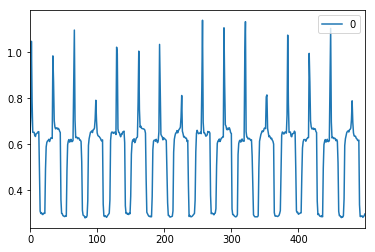

In [17]:
# Assumption1:
# 取出所有信号波谷的斜率，这个的角度比值应该显著小于1，而一等波应该几乎等于1
path = skew_train_path[4]
path = '/Volumes/workspace/projects/signal_classification/data/特殊次品样本/20200428高低脚102/2.上高低脚-25个/20200416_095952522/Channel_6.csv'
signals = pd.read_csv(path, skiprows=1, header=None)
signals[0:500].plot()

NameError: name 'get_vallay_height_features' is not defined

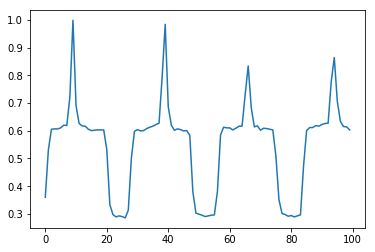

In [5]:
signal_mgr = SignalMgr()
dt, raw_signals = signal_mgr.parse_signals_from_file('/Users/changkong/workspace/signal_classification/projects/signal_classification/data/特殊次品样本/20191231统计数据-1/一等波-2036/20191216_073902392/Channel_2.csv', 1)
print(plt.plot(raw_signals[0:100]))
features = signal_mgr.get_features(path, request_param={'skip_row': [1], 'model_path': ['train']})
valley_height_diff = get_vallay_height_features(raw_signals, features['paired_edges'])
print(valley_height_diff)

In [ ]:
features.keys()

In [ ]:
def get_vallay_height_features(raw_signals, paired_edges, n_seg=4):
    valley_pos = []
    for i in range(1, len(paired_edges)):
        last_down = paired_edges[i - 1][1]
        cur_up = paired_edges[i][0]
        valley_pos.append((last_down[1] + cur_up[0]) // 2)
    valley_height = [0.0] * n_seg
#     print(valley_height)
    num = len(valley_pos) // n_seg
    for start in range(0, n_seg):
        tmp_valley_height = []
        for index in range(start, len(valley_pos), n_seg):
            tmp_valley_height.append(raw_signals[valley_pos[index]])
#             print(valley_pos[index], raw_signals[valley_pos[index]])
        valley_height[start] = np.mean(tmp_valley_height)
    return abs(np.max(valley_height) - np.min(valley_height))

In [ ]:
def get_edge_flattenness(raw_signals, edge):
    height_diff = []
    for point in range(edge[0] + 1, edge[1]):
        height_diff.append(abs(raw_signals[point] - raw_signals[point - 1]))
    height_diff = sorted(height_diff, reverse=True)
    # second largest
#     print(height_diff[1])
    #second best is important
    if len(height_diff) <= 1:
        return 0.0
    return height_diff[1]
    
def get_valley_flatenness_features(raw_signals, paired_edges):
    valley_flatten_level_1 = 0
    valley_flatten_level_2 = 0
    valley_flatten_level_3 = 0
    for up, down in paired_edges:
        up_flattenness = get_edge_flattenness(raw_signals, up)
#         print("left", up_flattenness)
        down_flattenness = get_edge_flattenness(raw_signals, down)
#         print("right", down_flattenness)
        flattenness = abs(up_flattenness - down_flattenness)
        if flattenness <= 0.02:
            valley_flatten_level_1 += 1
        elif flattenness <= 0.07:
            valley_flatten_level_2 += 1
        else:
            valley_flatten_level_3 += 1
    return valley_flatten_level_1, valley_flatten_level_2, valley_flatten_level_3

In [ ]:
flattenness = get_valley_flatenness_features(raw_signals, features['paired_edges'])
# print(flattenness)

In [ ]:
bin1 = []
bin2 = []
bin3 = []
for path in skew_train_path:
    dt, raw_signals = signal_mgr.parse_signals_from_file(path, 1)
    features = signal_mgr.get_features(path, request_param={'skip_row': [1], 'model_path': ['train']})
    flattenness = get_valley_flatenness_features(raw_signals, features['paired_edges'])
    bin1.append(flattenness[0])
    bin2.append(flattenness[1])
    bin3.append(flattenness[2])
skew_train_df['bin1'] = bin1
skew_train_df['bin2'] = bin2
skew_train_df['bin3'] = bin3

In [ ]:
skew_train_df

In [ ]:
# valley_diff_features = []
# for path in skew_train_path:
# #     print(path)
#     dt, raw_signals = signal_mgr.parse_signals_from_file(path, 1)
#     features = signal_mgr.get_features(path, request_param={'skip_row': [1], 'model_path': ['train']})
#     valley_height_diff = get_vallay_height_features(raw_signals, features['paired_edges'])
#     valley_diff_features.append(valley_height_diff)
# #     break
# print(np.mean(valley_diff_features))
# print(raw_signals[26])
# print(raw_signals[55])
# print(raw_signals[87])
# print(raw_signals[114])